In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels
import statsmodels.api as sm
from sktime.forecasting.arima import AutoARIMA

In [279]:
df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [280]:
df.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [281]:
df = df.dropna()
df.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [282]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['cbwd'] = le.fit_transform(df['cbwd'])

df = df.iloc[:,1:] # remove row number column
df

/tmp/ipykernel_120/2253441171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cbwd'] = le.fit_transform(df['cbwd'])


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,2010,1,2,0,129.0,-16,-4.0,1020.0,2,1.79,0,0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,2,2.68,0,0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,2,3.57,0,0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,2,5.36,1,0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,1,231.97,0,0
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,1,237.78,0,0
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,1,242.70,0,0
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,1,246.72,0,0


In [283]:
# convert to datetime
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']], format='%Y/%m/%d, %H')

In [284]:
df = df.drop(['year','month','day','hour'], axis = 1)
df = df.reset_index()
df = df[['datetime','pm2.5','DEWP','PRES','cbwd','Iws','Is','Ir']]
df

,datetime,pm2.5,DEWP,PRES,cbwd,Iws,Is,Ir
0,2010-01-02 00:00:00,129.0,-16,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
41752,2014-12-31 19:00:00,8.0,-23,1034.0,1,231.97,0,0
41753,2014-12-31 20:00:00,10.0,-22,1034.0,1,237.78,0,0
41754,2014-12-31 21:00:00,10.0,-22,1034.0,1,242.70,0,0
41755,2014-12-31 22:00:00,8.0,-22,1034.0,1,246.72,0,0


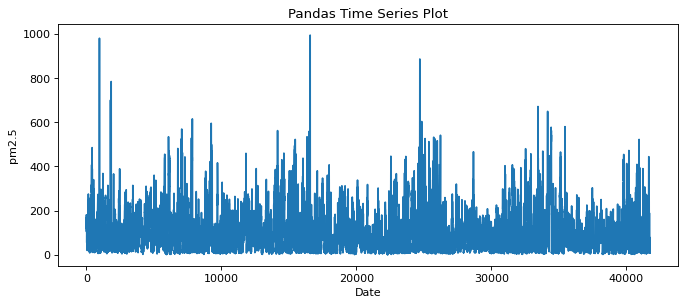

In [285]:
x = df['datetime']
y = df['pm2.5']
plt.figure(figsize = (10, 4), dpi = 80)
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.title("Pandas Time Series Plot")
plt.plot(range(len(x)), y)
plt.show()

## Implement Augmented Dickey-Fuller Test 
Check if the data is stationary or non-stationary

In [286]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
    print(out.to_string())   
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

In [287]:
tmp_df = df.drop('datetime',axis=1)
for item in tmp_df:
    print('ADF test result of {}:'.format(item))
    adf_test(df[item])
    print('----------------------------------------------')

ADF test result of pm2.5:
Augmented Dickey-Fuller Test: 
ADF test statistic        -20.606825
p-value                     0.000000
# lags used                54.000000
# observations          41702.000000
critical value (1%)        -3.430507
critical value (5%)        -2.861609
critical value (10%)       -2.566807
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------
ADF test result of DEWP:
Augmented Dickey-Fuller Test: 
ADF test statistic     -5.963564e+00
p-value                 2.012344e-07
# lags used             5.500000e+01
# observations          4.170100e+04
critical value (1%)    -3.430507e+00
critical value (5%)    -2.861609e+00
critical value (10%)   -2.566807e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------
ADF test result of PRES:
Augmented Dickey-Fuller Test

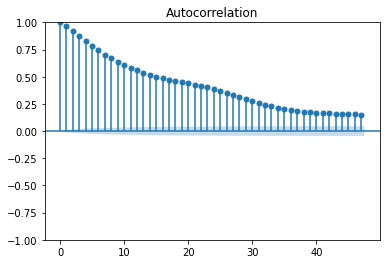

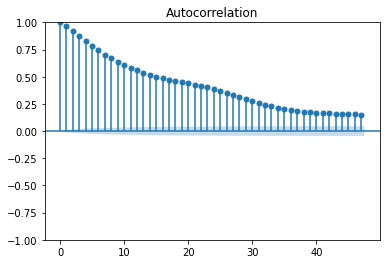

In [288]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df[Y_col])

## Split the data into train and test

In [289]:
feature_col = ['DEWP','PRES','cbwd','Iws','Is','Ir']
target_col = ['pm2.5']

train_size = int(0.70 * len(df))

multivariate_df = df[['datetime'] + target_col + feature_col].copy()
multivariate_df.columns = ['ds', 'y'] + feature_col

train = multivariate_df.iloc[:train_size, :]
X_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
X_test, y_test = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

## Modeling 


### 1. ARIMA

In [292]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(y_train, order=(1,1,1))
arima_model = arima_model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                29229
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -135779.968
Date:                Sat, 16 Apr 2022   AIC                         271565.936
Time:                        14:22:09   BIC                         271590.785
Sample:                             0   HQIC                        271573.919
                              - 29229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1424      0.008    -17.505      0.000      -0.158      -0.126
ma.L1          0.3256      0.008     43.138      0.000       0.311       0.340
sigma2       634.9759      0.844    752.725      0.0

In [293]:
# Predict on test set
arima_y_pred = arima_model.predict(start=X_train.shape[0],end=(X_train.shape[0]+X_test.shape[0]-1))

# Evaludate the model
score_mae = mean_absolute_error(y_test, arima_y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, arima_y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 102.2829744174831


### 2. SARIMAX

In [294]:
sari_model = sm.tsa.statespace.SARIMAX(df['pm2.5'], trend='c', order=(1,1,(1,0,0,1)))
sari_model = sari_model.fit(disp=False)
print(sari_model.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     pm2.5   No. Observations:                41757
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood             -192180.313
Date:                   Sat, 16 Apr 2022   AIC                         384370.626
Time:                           14:23:08   BIC                         384413.824
Sample:                                0   HQIC                        384384.271
                                 - 41757                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0027      0.155     -0.017      0.986      -0.306       0.301
ar.L1         -0.0776      0.007    -10.732      0.000      -0.092      -0.063
ma.L1          0.2583      0

In [296]:
# Predict on test set
sari_y_pred = sari_model.predict(start=X_train.shape[0],end=(X_train.shape[0]+X_test.shape[0]-1))

# Evaludate the model
score_mae = mean_absolute_error(y_test, sari_y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, sari_y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 21.44040962481422


### 3. PROPHET

In [ ]:
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import math

# Train the model
pro_model = Prophet()
pro_model.add_regressor('DEWP')
pro_model.add_regressor('PRES')
pro_model.add_regressor('cbwd')
pro_model.add_regressor('Iws')
# model.add_regressor('Is')
# model.add_regressor('Ir')

# Fit the model with train set
pro_model.fit(train)

# Predict on valid set
pro_y_pred = pro_model.predict(X_test)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, pro_y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, pro_y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

### 이 밑으로는 다 에러떠서 걍 냅둔 것들..^^

In [252]:
model = VAR(tmp_df)
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,25.68,25.68,1.424e+11,25.68
1,8.264,8.276,3882.,8.268
2,8.112,8.133,3333.,8.119
3,8.032,8.064,3079.,8.043
4,8.019,8.061,3038.,8.032
5,8.009,8.061,3008.,8.025
6,7.990,8.052*,2951.,8.010
7,7.981,8.054,2926.,8.004
8,7.978,8.061,2917.,8.004
9,7.974,8.066,2903.,8.003


In [253]:
result = model.fit(6)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Apr, 2022
Time:                     13:54:05
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    8.05488
Nobs:                     41751.0    HQIC:                   8.01227
Log likelihood:          -581243.    FPE:                    2958.97
AIC:                      7.99260    Det(Omega_mle):         2937.72
--------------------------------------------------------------------
Results for equation pm2.5
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const          -52.084850        18.843943           -2.764           0.006
L1.pm2.5         1.118024         0.004938          226.403           0.000
L1.DEWP          1.781221         0.085436           20.849           0.000
L1.P

In [261]:
# Predict on valid set
# y_pred = result.predict(start=X_train.shape[0],end=(X_train.shape[0]+X_test.shape[0]-1))
y_pred = res.forecast((X_train.shape[0]+X_test.shape[0]-1))
# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE: {}'.format(score_rmse))

ValueError: Found input variables with inconsistent numbers of samples: [8352, 41756]

In [229]:
# 실패 ^_^.... 그냥 무시해도 돼


from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1])))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
lstm_model.fit(X_train.to_numpy('timedelta64[ns]') , y_train.to_numpy('timedelta64[ns]') , batch_size=1, epochs=5, validation_data=(X_test.to_numpy('timedelta64[ns]') , y_test.to_numpy('timedelta64[ns]') ))

model.summary()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_TIMEDELTA).